<a href="https://colab.research.google.com/github/Piazo/ProjetIntegrateur/blob/devMatthieu/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

tf.random.set_seed(42)


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Création des Dataframes

data = pd.read_csv("revised_dataset.csv", sep=";")
data = data.astype(float)
df = data.head(2000)

df1 = data[['Latence1']]

df2 = data[['Latence2']]

df3 = data[['Latence3']]


# On rajoute une colonne moyenne des N dernières latences
df1['moyenne'] = df1['Latence1'].rolling(4).mean()
df2['moyenne'] = df2['Latence2'].rolling(4).mean()
df3['moyenne'] = df3['Latence3'].rolling(4).mean()

# On rajoute une colonne medianne des N dernières latences
df1['med'] = df1['Latence1'].rolling(3).median()
df2['med'] = df2['Latence2'].rolling(3).median()
df3['med'] = df3['Latence3'].rolling(3).median()

# On vire les premieres...
df1.dropna(inplace=True)
df2.dropna(inplace=True)
df3.dropna(inplace=True)

# colonne cible
target_col = 'med'

Latence1 = df1['Latence1']
Latence2= df2['Latence2']
Latence3 = df3['Latence3']

# On enlève la latence sur les 3 dataframes
df1 = df1.drop(columns=['Latence1'])
df2 = df2.drop(columns=['Latence2'])
df3 = df3.drop(columns=['Latence3'])

df1.head()

<ipython-input-2-13bdf101a507>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['moyenne'] = df1['Latence1'].rolling(4).mean()
<ipython-input-2-13bdf101a507>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['moyenne'] = df2['Latence2'].rolling(4).mean()
<ipython-input-2-13bdf101a507>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

,moyenne,med
3,0.319050,0.186139
4,0.213544,0.186139
5,0.215824,0.167115
6,0.188665,0.167115
7,0.201147,0.236069


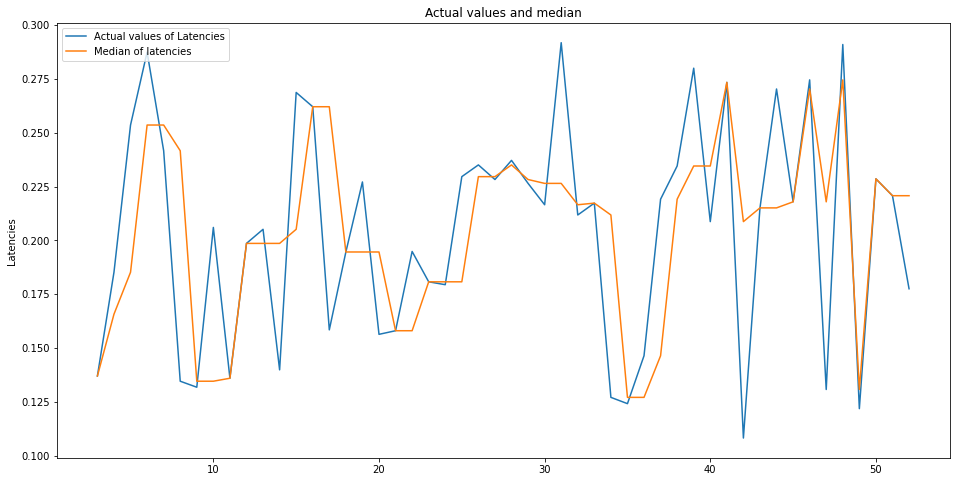

In [ ]:
def plotMedianAndLatency(node, start=0, end=50):
    plt.figure(figsize = (16,8))
    plt.title('Actual values and median') # setting plot title
    plt.ylabel('Latencies')

    if node == 1:    
        plt.plot(Latence1[start:end])
        plt.plot(df1['med'][start:end])
    elif node == 2:
        plt.plot(Latence2[start:end])
        plt.plot(df2['med'][start:end])
    elif node == 3:
        plt.plot(Latence3[start:end])
        plt.plot(df3['med'][start:end])

    plt.legend(['Actual values of Latencies','Median of latencies'], loc= 'upper left')
    plt.show()

plotMedianAndLatency(2)

In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data


In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=6, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    

    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model


In [ ]:
np.random.seed(42)
window_len = 6
test_size = 0.2
zero_base = False

lstm_neurons = 32

epochs = 50
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
# Création des variables utiles pour le modèle

train1, test1, X_train1, X_test1, y_train1, y_test1 = prepare_data(
    df1, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

train2, test2, X_train2, X_test2, y_train2, y_test2 = prepare_data(
    df2, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

train3, test3, X_train3, X_test3, y_train3, y_test3 = prepare_data(
    df3, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)


# Modele pour le node 1
model1 = build_lstm_model(
    X_train1, output_size=1, dropout=dropout, loss=loss, neurons=lstm_neurons,
    optimizer=optimizer)

history1 = model1.fit(
    X_train1, y_train1, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
1000/1000 [==============================] - 7s 5ms/step - loss: 0.0155
Epoch 2/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0101
Epoch 3/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0089
Epoch 4/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0081
Epoch 5/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0078
Epoch 6/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0076
Epoch 7/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0075
Epoch 8/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0075
Epoch 9/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0075
Epoch 10/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0075
Epoch 11/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0075
Epoch 12/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0074
E

In [ ]:
# Modele pour le node 2
model2 = build_lstm_model(
    X_train2, output_size=1, dropout=dropout, loss=loss, neurons=lstm_neurons,
    optimizer=optimizer)

history2 = model2.fit(
    X_train2, y_train2, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
1000/1000 [==============================] - 7s 5ms/step - loss: 0.0022
Epoch 2/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0014
Epoch 3/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0012
Epoch 4/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0011
Epoch 5/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0010
Epoch 6/50
1000/1000 [==============================] - 5s 5ms/step - loss: 9.8880e-04
Epoch 7/50
1000/1000 [==============================] - 5s 5ms/step - loss: 9.6508e-04
Epoch 8/50
1000/1000 [==============================] - 7s 7ms/step - loss: 9.5851e-04
Epoch 9/50
1000/1000 [==============================] - 5s 5ms/step - loss: 9.5309e-04
Epoch 10/50
1000/1000 [==============================] - 5s 5ms/step - loss: 9.4851e-04
Epoch 11/50
1000/1000 [==============================] - 5s 5ms/step - loss: 9.4633e-04
Epoch 12/50
1000/1000 [==============================] - 5s 5

In [ ]:
# Modele pour le node 3
model3 = build_lstm_model(
    X_train3, output_size=1, dropout=dropout, loss=loss, neurons=lstm_neurons,
    optimizer=optimizer)

history3 = model3.fit(
    X_train3, y_train3, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
1000/1000 [==============================] - 8s 5ms/step - loss: 0.0043
Epoch 2/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0031
Epoch 3/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0029
Epoch 4/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0026
Epoch 5/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0025
Epoch 6/50
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0024
Epoch 7/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0024
Epoch 8/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0024
Epoch 9/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0024
Epoch 10/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.0024
Epoch 11/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0024
Epoch 12/50
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0024
E

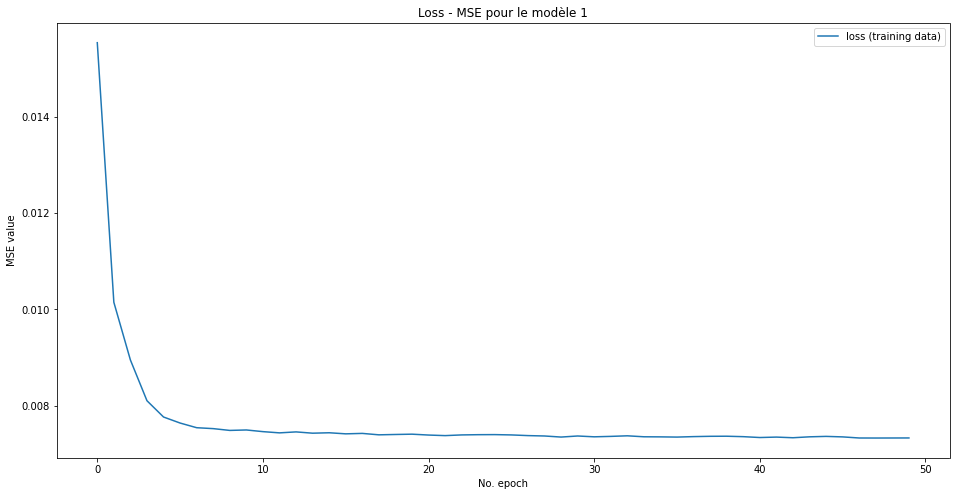

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(history1.history['loss'], label='loss (training data)')
plt.title('Loss - MSE pour le modèle 1')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [ ]:
#Getting predicted values 
predictions1 = model1.predict(X_test1).squeeze()
predictions2 = model2.predict(X_test2).squeeze()
predictions3 = model3.predict(X_test3).squeeze()


#get (RMSE) = root mean squared error. Shows how better the model predict

rmse1 = np.sqrt(np.mean(predictions1 - y_test1)**2)
rmse2 = np.sqrt(np.mean(predictions2 - y_test2)**2)
rmse3 = np.sqrt(np.mean(predictions3 - y_test3)**2)


print("rmse 1 :", rmse1)
print("rmse 2 :", rmse2)
print("rmse 3 :", rmse3)

250/250 [==============================] - 1s 2ms/step
rmse 1 : 0.006575994533296985
rmse 2 : 0.0005669626934007651
rmse 3 : 0.0038095484457165763


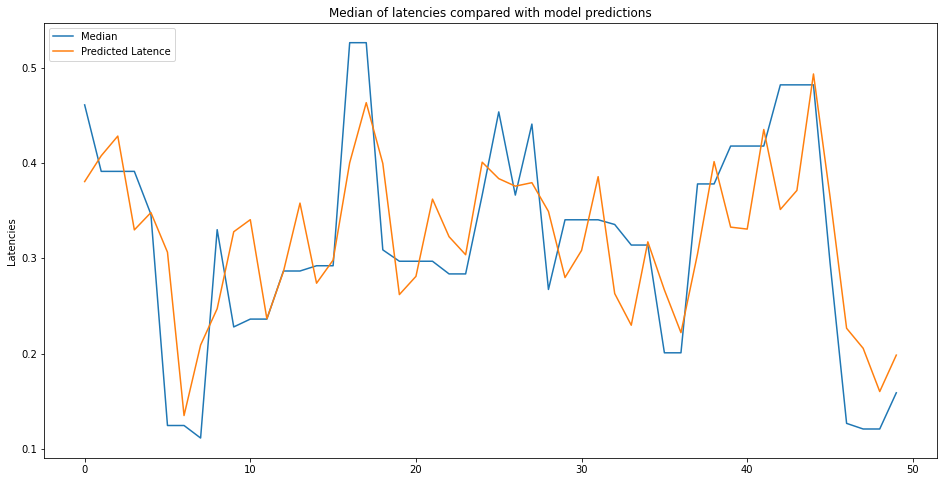

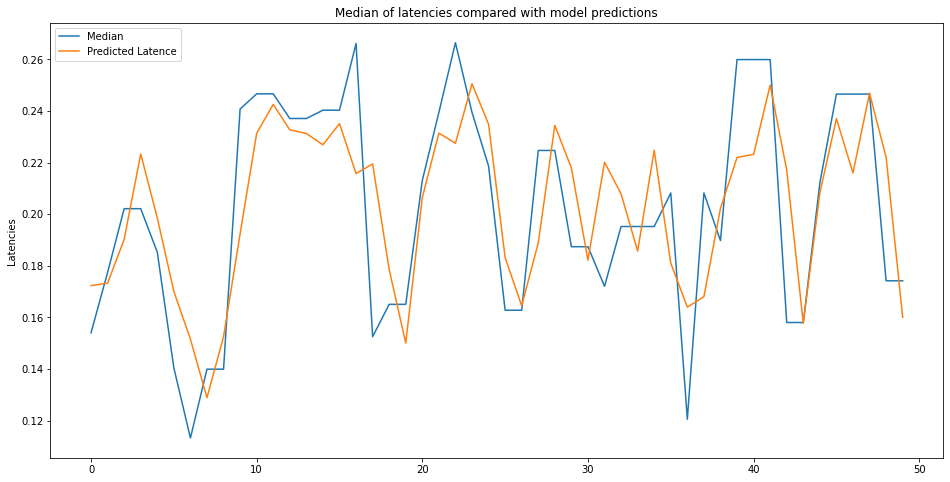

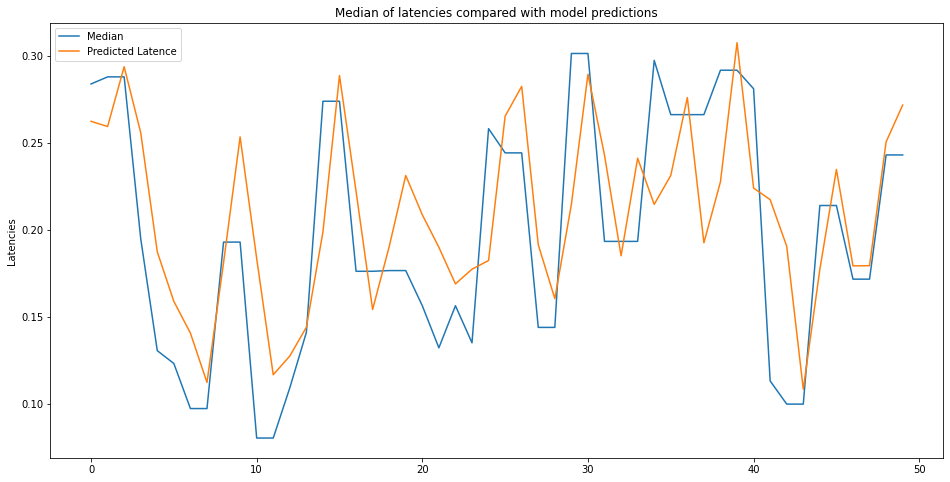

In [ ]:
#visualizing predicted and actual values

def predAndMedian(node, start=0, end = 50):
    plt.figure(figsize = (16,8))
    plt.title('Median of latencies compared with model predictions')
    plt.ylabel('Latencies')

    if node == 1:
        plt.plot(y_test1[start:end])
        plt.plot(predictions1[start:end])
    elif node == 2:
        plt.plot(y_test2[start:end])
        plt.plot(predictions2[start:end])
    elif node == 3:
        plt.plot(y_test3[start:end])
        plt.plot(predictions3[start:end])

    plt.legend(['Median','Predicted Latence'], loc= 'upper left')
    plt.show()

predAndMedian(1)
predAndMedian(2)
predAndMedian(3)

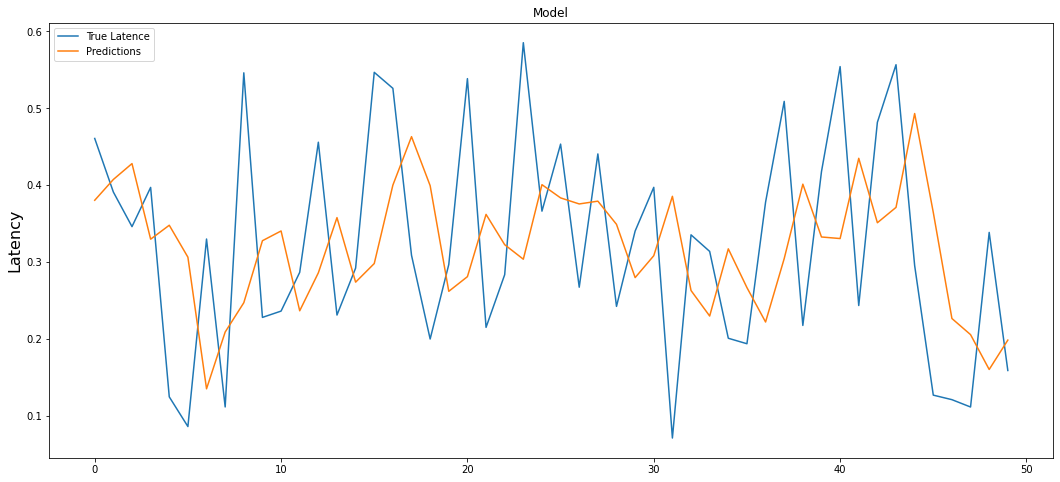

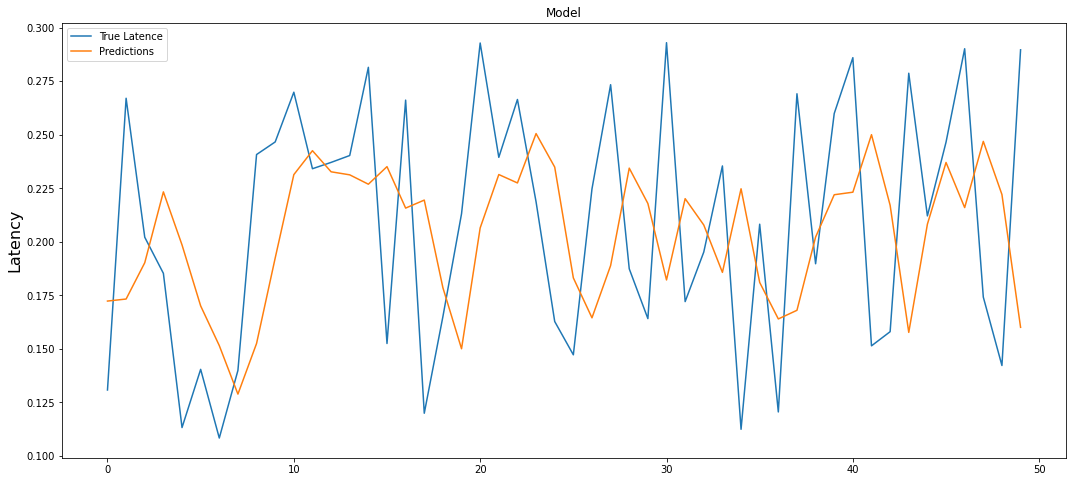

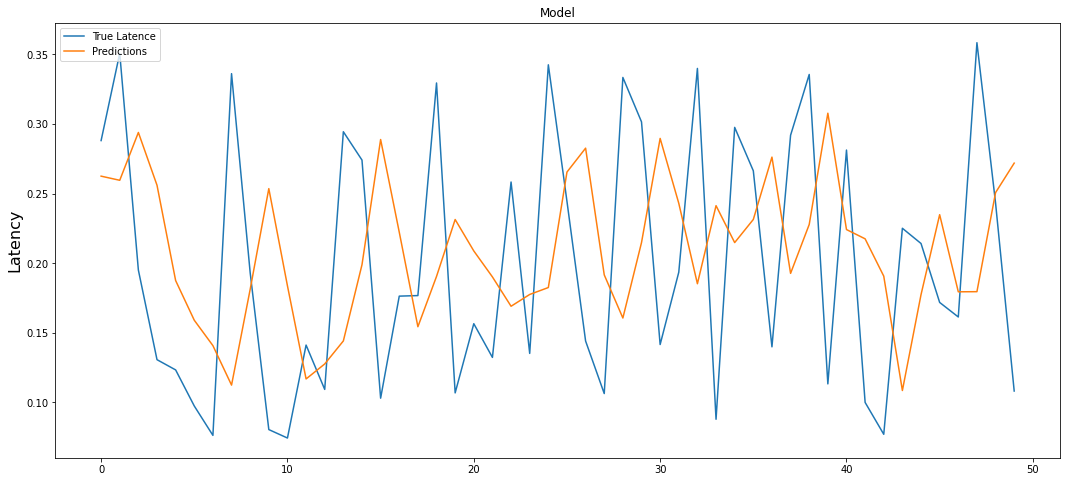

In [ ]:
def TrueLatencyAndPred(node, start=0, end=50, transfo=False):
    plt.figure(figsize=(18, 8))
    plt.title('Model')
    plt.ylabel('Latency', fontsize = 16)

    if not transfo:
        if node == 1:
            ecart = len(Latence1) - len(predictions1)
            plt.plot(Latence1[ecart:-1].values[start:end])
            plt.plot(predictions1[start:end])
        if node == 2:
            ecart = len(Latence2) - len(predictions2)
            plt.plot(Latence2[ecart:-1].values[start:end])
            plt.plot(predictions2[start:end])
        if node == 3:
            ecart = len(Latence3) - len(predictions3)
            plt.plot(Latence3[ecart:-1].values[start:end])
            plt.plot(predictions3[start:end]) 

        plt.legend(['True Latence', 'Predictions'], loc= 'upper left')
        plt.show()



TrueLatencyAndPred(node=1, start=0, end=50)
TrueLatencyAndPred(node=2, start=0, end=50)
TrueLatencyAndPred(node=3, start=0, end=50)

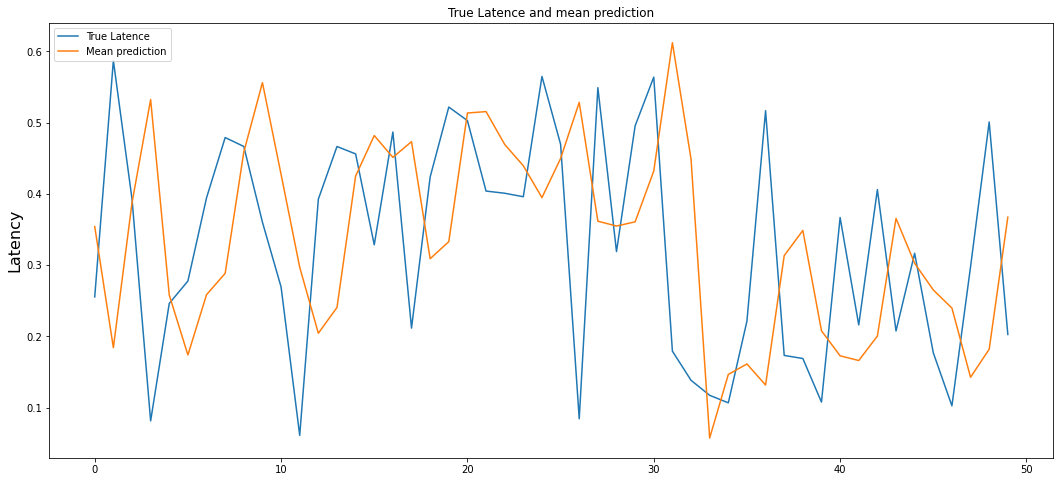

In [ ]:
moy = np.mean(predictions)

new_pred = (predictions - moy)*1.5 + moy


plt.figure(figsize=(18, 8))
plt.title('True Latence and mean prediction')
plt.ylabel('Latency', fontsize = 16)

plt.plot(Latence[ecart:-1].values[150:200])
plt.plot(new_pred[150:200])


plt.legend(['True Latence', 'Mean prediction'], loc= 'upper left')

plt.show()


In [ ]:
#Getting predicted values 
predictions2 = model.predict(X_test2).squeeze()

#get (RMSE) = root mean squared error. Shows how better the model predict

rmse = np.sqrt(np.mean(predictions2 - y_test2)**2)

print("rmse :", rmse)

250/250 [==============================] - 0s 2ms/step
rmse : 0.04539785686320591


In [ ]:
print(model.predict([[
    [0.2, 0.4],
    [0.2, 0.5],
    [0.9, 0.33],
    [0.7, 0.9],
    [0.2, 0.1],
    [0.5, 0.4]]]).squeeze())

1/1 [==============================] - 0s 32ms/step
0.058715418


In [ ]:
# Save the entire model as a SavedModel.

!mkdir -p saved_model

model1.save('saved_model/Node1')
model2.save('saved_model/Node2')
model3.save('saved_model/Node3')

In [ ]:
new_model = tf.keras.models.load_model('saved_model/Node1')
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4480      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 4,513
Trainable params: 4,513
Non-trainable params: 0
_________________________________________________________________


In [ ]:
latences = [0.3, 0.4, 0.4, 0.23, 0.66, 0.6, 0.4, 0.3, 0.22]


def createDataForPred(latences):

    df = pd.DataFrame()

    print("AVANT CALCUL")

    df['val'] = latences

    print(df)

    print("APRES CALCUL")

    df['median'] = df['val'].rolling(3).median()
    df['mean'] = df['val'].rolling(4).mean()

    # On enlève la latence
    df = df.drop(columns=['val'])

    # Les 3 premières valeurs sont NaN, c'est normal
    print(df)

    print("On enlève les colonnes NaN ")
    df.dropna(inplace=True)
    print(df)

    # df comporte maintenant 6 valeurs, on peut faire des predictions dessus : 
    print("\nPredictions\n")

    # On le met en format list

    return [df.values.tolist()]


lat = createDataForPred(latences)


print(new_model.predict(lat))

AVANT CALCUL
    val
0  0.30
1  0.40
2  0.40
3  0.23
4  0.66
5  0.60
6  0.40
7  0.30
8  0.22
APRES CALCUL
   median    mean
0     NaN     NaN
1     NaN     NaN
2     0.4     NaN
3     0.4  0.3325
4     0.4  0.4225
5     0.6  0.4725
6     0.6  0.4725
7     0.4  0.4900
8     0.3  0.3800
On enlève les colonnes NaN 
   median    mean
3     0.4  0.3325
4     0.4  0.4225
5     0.6  0.4725
6     0.6  0.4725
7     0.4  0.4900
8     0.3  0.3800

Predictions

1/1 [==============================] - 0s 56ms/step
[[0.08837967]]


In [ ]:
# Ajouter des nouvelles valeurs